In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
import joblib
import shap


#### **Exploratory Data Analysis**

*Basic info* quickly understand shape, types, missing / suspicious values, class balance, and basic statistics

In [2]:
# load data
df = pd.read_csv(r"C:\Users\Shahe\OneDrive\Desktop\ml_project\diabetes.csv") 

In [3]:
# shape of the data
print("Shape:", df.shape)

Shape: (768, 9)


In [4]:
# first few rows
display(df.head())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# basic info, data types, missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# Descriptive stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [7]:
# Class balance
print("Outcome counts:", )
display(df['Outcome'].value_counts())

Outcome counts:


Outcome
0    500
1    268
Name: count, dtype: int64

In [8]:
# Class balance
print("Outcome proportions:")
display(df['Outcome'].value_counts(normalize=True))

Outcome proportions:


Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64

In [9]:
# correlation 
display(df.corr().round(3))

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


#### **Preprocessing**
*prepare data for modeling*: fix missing values (zeros), split into train/test, and scale numeric features.

In [10]:
# Check zeros in features that shouldn't be zero
cols_with_zeros = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']
zero_counts = (df[cols_with_zeros] == 0).sum().sort_values(ascending=False)
print("\nZero counts (likely missing):")
zero_counts


Zero counts (likely missing):


Insulin          374
SkinThickness    227
BloodPressure     35
BMI               11
Glucose            5
dtype: int64

In [11]:
# replace zeros with NaN in features that shouldn't be zero
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

In [12]:
print("Missing after replace:")
df.isnull().sum()

Missing after replace:


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [13]:
# Median imputation is a robust and common technique because it prevents the imputed values from being skewed by outliers, unlike mean imputation.
imputer = SimpleImputer(strategy='median')
df[cols_with_zeros] = imputer.fit_transform(df[cols_with_zeros])
print("Missing after imputation:")
df.isnull().sum()

Missing after imputation:


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [14]:
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,121.656250,30.438286,44.000,99.75000,117.0000,140.25000,199.00
BloodPressure,768.0,72.386719,12.096642,24.000,64.00000,72.0000,80.00000,122.00
SkinThickness,768.0,29.108073,8.791221,7.000,25.00000,29.0000,32.00000,99.00
Insulin,768.0,140.671875,86.383060,14.000,121.50000,125.0000,127.25000,846.00
BMI,768.0,32.455208,6.875177,18.200,27.50000,32.3000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


#### *Visual EDA*

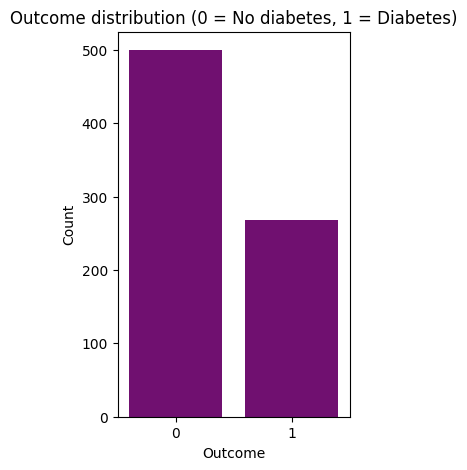

In [15]:

# Use the imputed dataframe from preprocessing step
df_plot = df.copy()

# Outcome distribution (bar)
plt.figure(figsize=(3,5))
sns.countplot(data=df_plot, x='Outcome', color='purple')
plt.title('Outcome distribution (0 = No diabetes, 1 = Diabetes)')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()


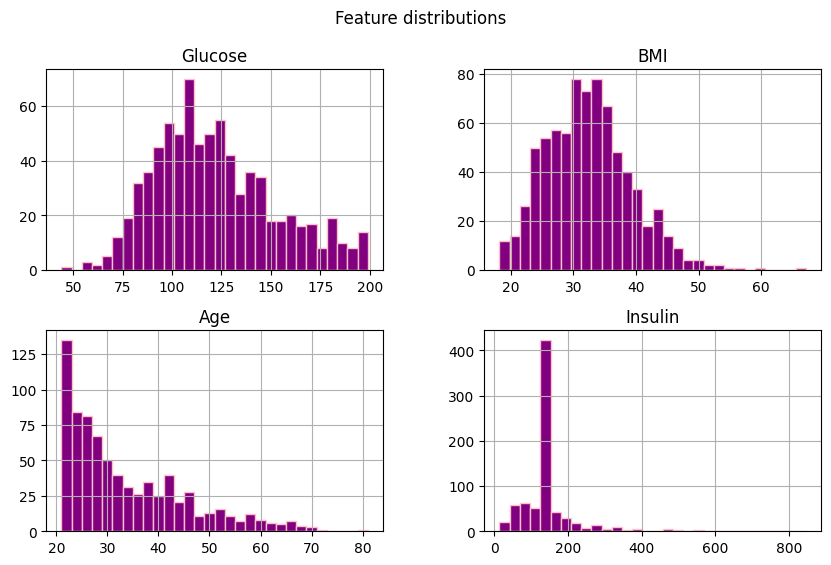

In [16]:
# Histograms of selected key features
key_feats = ['Glucose','BMI','Age','Insulin']
df_plot[key_feats].hist(bins=30, figsize=(10,6), color='purple', edgecolor='pink')
plt.suptitle('Feature distributions')
plt.show()

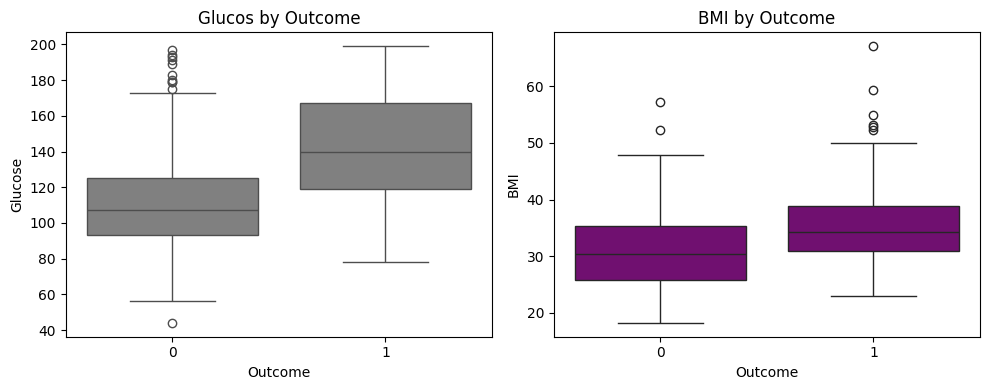

In [17]:
# Boxplots of features by outcome (BMI & BMI_log are most informative)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.boxplot(x='Outcome', y='Glucose', data=df, color='gray')
plt.title('Glucos by Outcome')
plt.subplot(1,2,2)
sns.boxplot(x='Outcome', y='BMI', data=df, color='purple')
plt.title('BMI by Outcome')
plt.tight_layout()
plt.show()

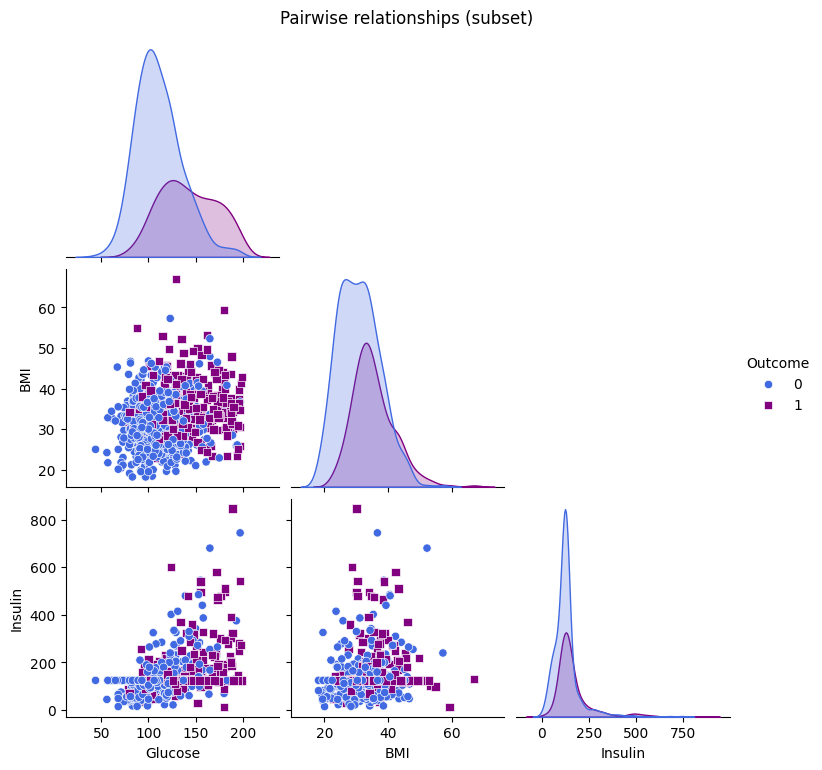

In [18]:
# Pairplot for a subset 
subset = ['Glucose','BMI','Insulin','Outcome']
sns.pairplot(df_plot[subset], hue='Outcome', markers=["o","s"], diag_kind='kde', corner=True, palette={ "royalblue",  "purple"})
plt.suptitle('Pairwise relationships (subset)', y=1.02)
plt.show()

#### *Handling Skewed Distributions*
Features like Insulin, BMI and Age are right-skewed, to reduce extreme outliers, makes distribution closer to normal, and improves linear model's performance. Log-transform reduces extreme values’ influence, making the feature distribution more symmetric, stabilizing linear relationships, and improving models’ learning -especially for Logistic Regression-

In [19]:
# Log-transform skewed numeric features:
for col in ['Insulin','Glucose','BMI']:
    df[col + '_log'] = np.log1p(df[col])

# Drop original skewed columns:
df = df.drop(columns=['Insulin','Glucose','BMI'])

#### *Feature Engineering*
to transform continuous variables into more meaningful inputs for the model. First, the continuous 'Age' feature is converted into the categorical feature 'Age_group' by binning it into distinct ranges like '20-30' and '50+'. Similarly, the continuous 'BMI' is converted into the categorical feature 'BMI_cat' (e.g., 'Normal', 'Obese') using a custom function based on clinical guidelines, which simplifies the relationship to diabetes risk for the model. The process concludes by creating interaction terms by multiplying features like Glucose_log and Age to capture non-linear relationships, and then one-hot encoding the newly created categorical columns ('Age_group' and 'BMI_cat') into dummy variables, dropping the first level of each to prevent multicollinearity.


In [20]:
# converts a continuous variable into a categorical feature to let the model focuses on “risk group” patterns
df['Age_group'] = pd.cut(df['Age'], bins=[20,30,40,50,100], labels=['20-30','30-40','40-50','50+'])


# BMI category, converts a continuous variable into a categorical feature is easier for the model to relate BMI to risk.
# also clinically, diabetes risk is better captured by BMI categories than exact BMI numbers
def bmi_category(bmi):
    if bmi < 18.5: return 'Underweight'
    elif bmi < 25: return 'Normal'
    elif bmi < 30: return 'Overweight'
    else: return 'Obese'
df['BMI_cat'] = df['BMI_log'].apply(lambda x: bmi_category(np.expm1(x)))  


# Interaction terms, Captures relationships between features affect diabetes risk more than either feature alone
df['Glucose_log*Age'] = df['Glucose_log'] * df['Age']
df['BMI_log*Age'] = df['BMI_log'] * df['Age']

# One-hot encode categorical features
df = pd.get_dummies(df, columns=['Age_group','BMI_cat'], drop_first=True)

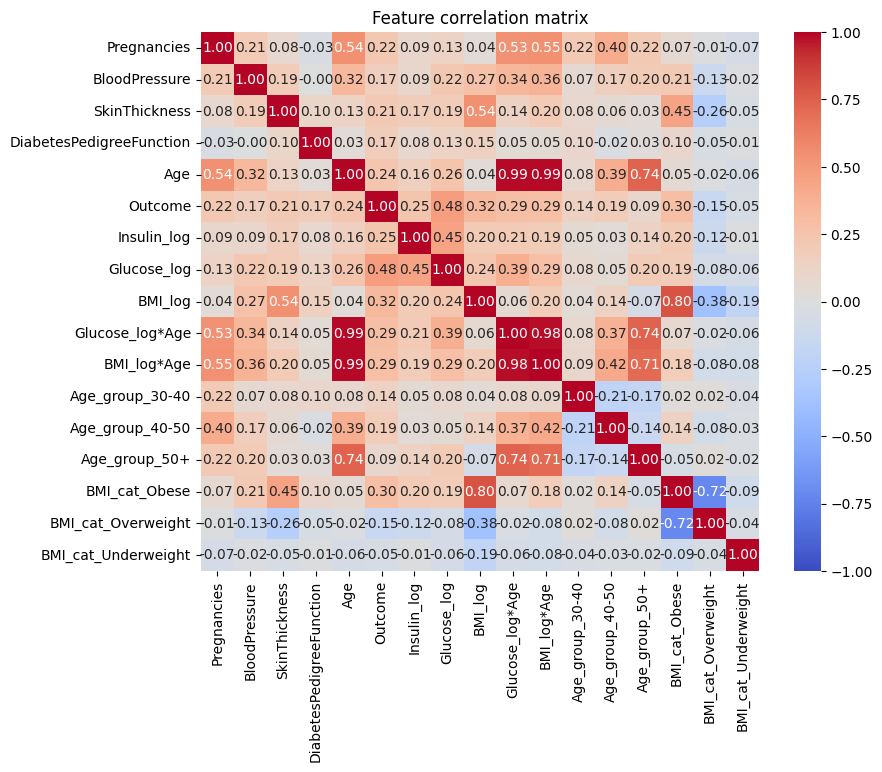

In [21]:
# Correlation heatmap
plt.figure(figsize=(9,7))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature correlation matrix')
plt.show()

In [22]:
df.to_csv(r"C:\Users\Shahe\OneDrive\Desktop\ml_project\new_diabetes.csv", index=False)

#### **Data Preparation and Splitting**
prepares a dataset for a machine learning model by first separating the features ($\mathbf{X}$) from the target outcome ($\mathbf{y}$). Next, it splits the data into $\mathbf{80\%}$ for training and $\mathbf{20\%}$ for testing using a stratified approach to keep the proportion of the outcome consistent in both sets, ensuring the results are reproducible with a set random_state. Finally, it applies StandardScaler to a specific list of numeric columns, fitting the transformation (calculating mean and standard deviation) only on the training data and then transforming both the training and test sets, a crucial step to standardize the data and prevent information leakage from the test set.

In [23]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale numeric features (especially for logistic regression)
numeric_cols = ['Pregnancies','BloodPressure','SkinThickness','DiabetesPedigreeFunction',
                'Age','Insulin_log','Glucose_log','BMI_log','Glucose_log*Age','BMI_log*Age']

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])


# Save the scaler for deployment
joblib.dump(scaler, r"C:\Users\Shahe\OneDrive\Desktop\ml_project\scaler.pkl")


print("Pipeline ready! Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


Pipeline ready! Shapes:
X_train: (614, 16)
X_test: (154, 16)
y_train: (614,)
y_test: (154,)


#### **Baseline Models**

*Logistic Regression Baseline*

In [24]:
log_model = LogisticRegression(random_state=42, max_iter=500)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:,1]

*RandomForest*

In [25]:
rf_model = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

##### **Evaluation**


In [26]:
def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"=== {model_name} ===")
    print("Recall:", recall_score(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print()

evaluate_model(y_test, y_pred_log, y_proba_log, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, y_proba_rf, "Stronger RandomForest")

# Compare recalls
recall_log = recall_score(y_test, y_pred_log)
recall_rf  = recall_score(y_test, y_pred_rf)
if recall_rf > recall_log:
    print("RandomForest has higher recall → better for medical priority.")
else:
    print("Logistic Regression has higher recall → better for medical priority.")

=== Logistic Regression ===
Recall: 0.5740740740740741
Accuracy: 0.7207792207792207
Precision: 0.6078431372549019
F1 Score: 0.5904761904761905
ROC-AUC: 0.8303703703703703
Confusion Matrix:
 [[80 20]
 [23 31]]

=== Stronger RandomForest ===
Recall: 0.6296296296296297
Accuracy: 0.7597402597402597
Precision: 0.6666666666666666
F1 Score: 0.6476190476190476
ROC-AUC: 0.826111111111111
Confusion Matrix:
 [[83 17]
 [20 34]]

RandomForest has higher recall → better for medical priority.


##### **Hyperparameter Tuning**
Random Forest model significantly outperforms Logistic Regression in identifying positive diabetic cases, achieving a Recall of approximately $63\%$ compared to the Logistic Regression's $57\%$. This higher recall rate is critical in a medical context, as it minimizes false negatives and prioritizes patient safety. To further optimize this capability, the next professional steps involve **hyperparameter tuning** on the Random Forest model specifically to maximize recall, rigorously evaluating the tuned model across all key performance metrics.

In [27]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale numeric features (for linear models, optional here)
numeric_cols = ['Pregnancies','BloodPressure','SkinThickness','DiabetesPedigreeFunction',
                'Age','Insulin_log','Glucose_log','BMI_log','Glucose_log*Age','BMI_log*Age']

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])


In [28]:
# Hyperparameter Tuning for RandomForest, Define parameter grid for tuning
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [4, 6, 8, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced'] 
}

# Use GridSearchCV to find best hyperparameters, scoring='recall' prioritizes catching diabetic patients
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Hyperparameters: {'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 400}


In [29]:
# Train RandomForest with best parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Predict
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:,1]

# Evaluate model
print("\n=== Tuned RandomForest Evaluation ===")
print("Recall:", recall_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


=== Tuned RandomForest Evaluation ===
Recall: 0.7777777777777778
Accuracy: 0.7337662337662337
Precision: 0.5915492957746479
F1 Score: 0.672
ROC-AUC: 0.8246296296296296
Confusion Matrix:
 [[71 29]
 [12 42]]


##### **Optimal Threshold Tuning for Constrained Recall**
The next step after the Random Forest model significantly outperforms Logistic Regression is to perform a comprehensive threshold tuning analysis to find the optimal decision boundary, balancing a minimum recall requirement with the best possible F1-score. This script automates that process by iterating through a range of potential probability thresholds (from $0.1$ to $0.9$), calculating a full suite of performance metrics (recall, precision, F1-score, and accuracy) for the test set predictions at each cutoff. These results are then systematically filtered to isolate a group of "candidate" thresholds that all meet a predefined minimum recall floor (e.g., $\ge 0.75$). From this qualified subset, the script identifies and selects the single optimal threshold that maximizes the F1-score (using precision and accuracy as tie-breakers), finally printing the chosen threshold, its balanced performance metrics, and the resulting confusion matrix.

In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, confusion_matrix

# y_test and y_proba must already exist (from best_rf.predict_proba(X_test)[:,1])
thresholds = np.arange(0.1, 0.91, 0.01)

rows = []
for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    rows.append({
        'threshold': t,
        'recall': recall_score(y_test, y_pred_t),
        'precision': precision_score(y_test, y_pred_t),
        'f1': f1_score(y_test, y_pred_t),
        'accuracy': accuracy_score(y_test, y_pred_t)
    })

df_thresh = pd.DataFrame(rows)

# Filter thresholds that meet recall constraint (>= 0.75)
recall_floor = 0.75
candidates = df_thresh[df_thresh['recall'] >= recall_floor]

if candidates.empty:
    print(f"No threshold achieves recall >= {recall_floor}. Consider lowering the floor or retraining.")
else:
    # choose the candidate with highest F1 (break ties by higher precision then accuracy)
    best_row = candidates.sort_values(['f1','precision','accuracy'], ascending=False).iloc[0]
    best_t = best_row['threshold']
    print("Selected threshold (Recall >= {:.2f}, best F1): {:.2f}".format(recall_floor, best_t))
    print(best_row)

    # Final evaluation at chosen threshold
    y_final = (y_proba >= best_t).astype(int)
    print("\nFinal confusion matrix:\n", confusion_matrix(y_test, y_final))
    print("Recall:", recall_score(y_test, y_final))
    print("Precision:", precision_score(y_test, y_final))
    print("F1:", f1_score(y_test, y_final))
    print("Accuracy:", accuracy_score(y_test, y_final))


Selected threshold (Recall >= 0.75, best F1): 0.55
threshold    0.550000
recall       0.759259
precision    0.661290
f1           0.706897
accuracy     0.779221
Name: 45, dtype: float64

Final confusion matrix:
 [[79 21]
 [13 41]]
Recall: 0.7592592592592593
Precision: 0.6612903225806451
F1: 0.7068965517241379
Accuracy: 0.7792207792207793


C:\Users\Shahe\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shahe\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Shahe\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\User

In [31]:
from sklearn.model_selection import cross_validate

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

cv_results = cross_validate(
    estimator=best_rf,
    X=X,
    y=y,
    cv=20,              # 5-fold cross-validation
    scoring=scoring,
    return_train_score=False
)

for metric in scoring.keys():
    print(f"{metric}: {cv_results['test_' + metric].mean():.4f}")


accuracy: 0.7647
precision: 0.6460
recall: 0.7912
f1: 0.7067
roc_auc: 0.8355


In [32]:
joblib.dump(best_rf, r"C:\Users\Shahe\OneDrive\Desktop\ml_project\rf_diabetes_model.pkl")
joblib.dump(X_train.columns, r"C:\Users\Shahe\OneDrive\Desktop\ml_project\trained_features.pkl")

['C:\\Users\\Shahe\\OneDrive\\Desktop\\ml_project\\trained_features.pkl']

#### **Deployment-Ready Prediction Pipeline with Custom Threshold**
After Optimal Threshold Tuning for Constrained Recall, the next step modularizes the entire feature engineering process—including log transformations, age/BMI binning, and interaction term creation—into a robust, deployment-ready prediction pipeline. This is encapsulated in a comprehensive `preprocess` function that correctly applies a pre-fitted `StandardScaler` to new, incoming data without refitting. To ensure production stability and prevent errors from mismatched features, a vital `align_features` function is implemented to guarantee that the feature set of new data perfectly matches the columns the model was trained on, adding missing one-hot encoded columns as zeros. The final `predict_diabetes` function serves as the main inference endpoint, seamlessly integrating this preprocessing and feature alignment, and then using the pre-loaded Random Forest model to generate probabilities, which are then converted into a final prediction using the custom-tuned `THRESHOLD` of 0.55.

In [33]:
# 1) Feature Engineering Functions
def log_transform_features(df):
    for col in ['Insulin', 'Glucose', 'BMI']:
        df[col + '_log'] = np.log1p(df[col])
    return df

def create_age_group(df):
    df['Age_group'] = pd.cut(df['Age'], bins=[20,30,40,50,100],
                             labels=['20-30','30-40','40-50','50+'])
    return df

def create_bmi_category(df):
    def bmi_category(bmi):
        if bmi < 18.5: return 'Underweight'
        elif bmi < 25: return 'Normal'
        elif bmi < 30: return 'Overweight'
        else: return 'Obese'
    df['BMI_cat'] = df['BMI_log'].apply(lambda x: bmi_category(np.expm1(x)))
    return df

def create_interactions(df):
    df['Glucose_log*Age'] = df['Glucose_log'] * df['Age']
    df['BMI_log*Age'] = df['BMI_log'] * df['Age']
    return df

# 2) Preprocessing function (training & new data)
def preprocess(df, scaler=None, fit_scaler=False):
    df = log_transform_features(df)
    df = create_age_group(df)
    df = create_bmi_category(df)
    df = create_interactions(df)
    
    # One-hot encoding for categorical features
    df = pd.get_dummies(df, columns=['Age_group', 'BMI_cat'], drop_first=False)
    
    # List of numeric columns to scale
    numeric_cols = ['Pregnancies','BloodPressure','SkinThickness','DiabetesPedigreeFunction',
                    'Age','Insulin_log','Glucose_log','BMI_log','Glucose_log*Age','BMI_log*Age']
    
    if scaler is None:
        scaler = StandardScaler()
        fit_scaler = True
    
    if fit_scaler:
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    else:
        df[numeric_cols] = scaler.transform(df[numeric_cols])
    
    return df, scaler

# 3) Align features to training columns
def align_features(df, trained_columns):
    for col in trained_columns:
        if col not in df.columns:
            df[col] = 0
    return df[trained_columns]

# 4) Prediction function with threshold
THRESHOLD = 0.55

def predict_diabetes(new_df, trained_features, scaler, model):
    # Preprocess
    df_proc, _ = preprocess(new_df.copy(), scaler=scaler, fit_scaler=False)
    
    # Align features with training
    X = align_features(df_proc, trained_features)
    
    # Predict probabilities
    proba = model.predict_proba(X)[:,1]
    
    # Apply threshold
    pred = (proba >= THRESHOLD).astype(int)
    
    df_result = new_df.copy()
    df_result['Predicted_Outcome'] = pred
    df_result['Probability'] = proba
    
    return df_result


# 5) Example usage
# Load trained model, scaler, and trained features
best_rf = joblib.load(r"C:\Users\Shahe\OneDrive\Desktop\ml_project\rf_diabetes_model.pkl")
scaler = joblib.load(r"C:\Users\Shahe\OneDrive\Desktop\ml_project\scaler.pkl")
trained_features = joblib.load(r"C:\Users\Shahe\OneDrive\Desktop\ml_project\trained_features.pkl")  

# Example new patients
new_patients = pd.DataFrame([
    {'Pregnancies': 2, 'Glucose': 120, 'BloodPressure': 70, 'SkinThickness': 25,
     'Insulin': 85, 'BMI': 28, 'DiabetesPedigreeFunction': 0.45, 'Age': 33},
    {'Pregnancies': 5, 'Glucose': 160, 'BloodPressure': 80, 'SkinThickness': 30,
     'Insulin': 150, 'BMI': 33, 'DiabetesPedigreeFunction': 0.67, 'Age': 45}
])

predictions = predict_diabetes(new_patients, trained_features, scaler, best_rf)
display(predictions)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Predicted_Outcome,Probability
0,2,120,70,25,85,28,0.45,33,0,0.357559
1,5,160,80,30,150,33,0.67,45,1,0.848606
